In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("Library Ready")

Library Ready


### BAGIAN 1: FONDASI (ORIGINAL WORK)
### Mencakup: Data Understanding, Cleaning, EDA, & Feature Engineering


--- [STEP 1] LOAD & CLEAN DATA ---
Info Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   hour_of_day  3547 non-null   int64         
 1   cash_type    3547 non-null   object        
 2   money        3547 non-null   float64       
 3   coffee_name  3547 non-null   object        
 4   Time_of_Day  3547 non-null   object        
 5   Weekday      3547 non-null   object        
 6   Month_name   3547 non-null   object        
 7   Weekdaysort  3547 non-null   int64         
 8   Monthsort    3547 non-null   int64         
 9   Date         3547 non-null   datetime64[ns]
 10  Time         3547 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 304.9+ KB

--- [STEP 2] EDA ---


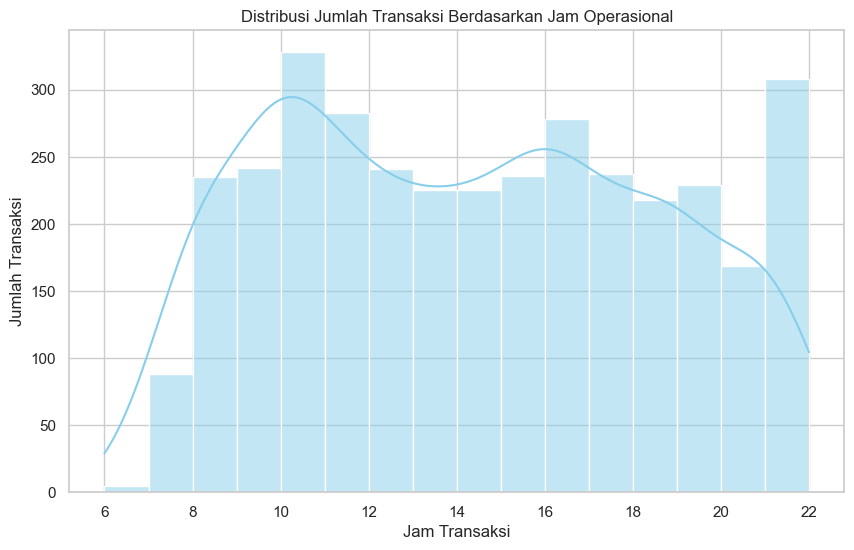

C:\Users\DANANG ADIWIBOWO\AppData\Local\Temp\ipykernel_28400\554468452.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


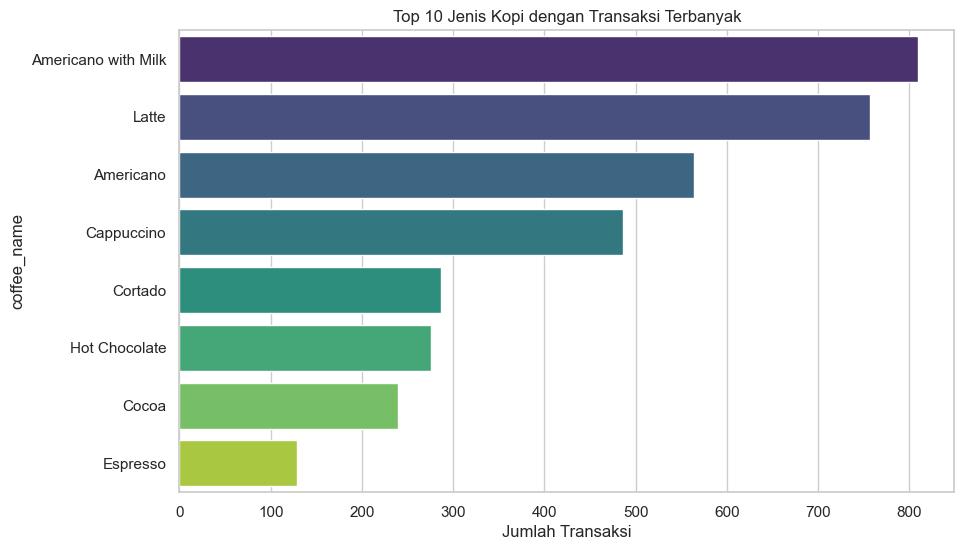

C:\Users\DANANG ADIWIBOWO\AppData\Local\Temp\ipykernel_28400\554468452.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Weekday', order=day_order, palette='viridis')


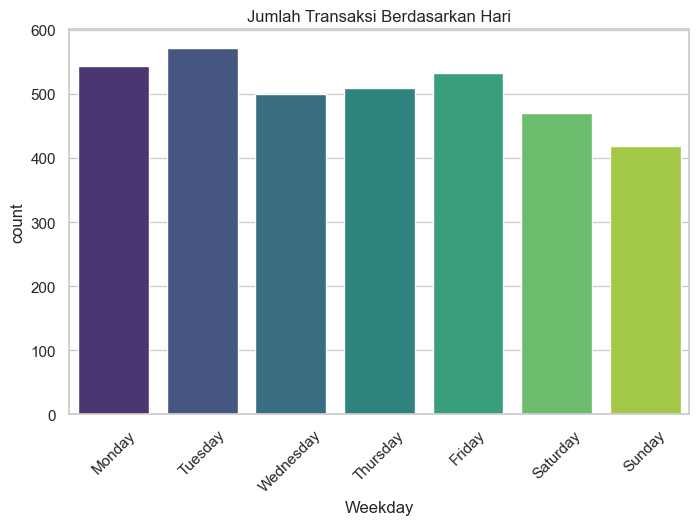

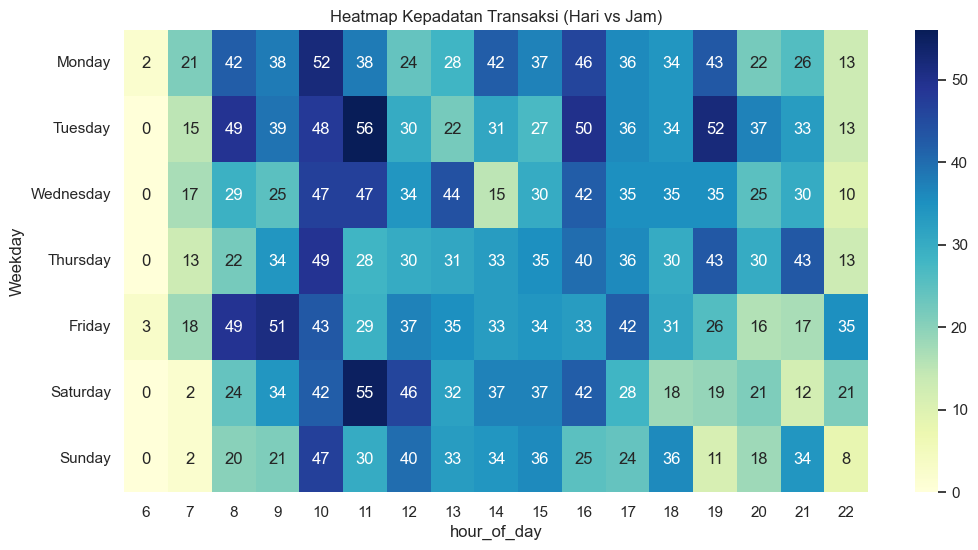


--- [STEP 3] DATA PREPARATION (AGREGASI & FEATURE ENGINEERING) ---
Threshold Peak Hour: > 2.0 order/jam
Data Siap Modeling:


,Date,hour_of_day,order_count,avg_ticket_size,day_name,month,is_peak_hour,day_code
0,2024-03-01,10,1,38.7,Friday,3,0,0
1,2024-03-01,12,2,38.7,Friday,3,0,0
2,2024-03-01,13,2,33.8,Friday,3,0,0
3,2024-03-01,15,1,33.8,Friday,3,0,0
4,2024-03-01,16,1,38.7,Friday,3,0,0


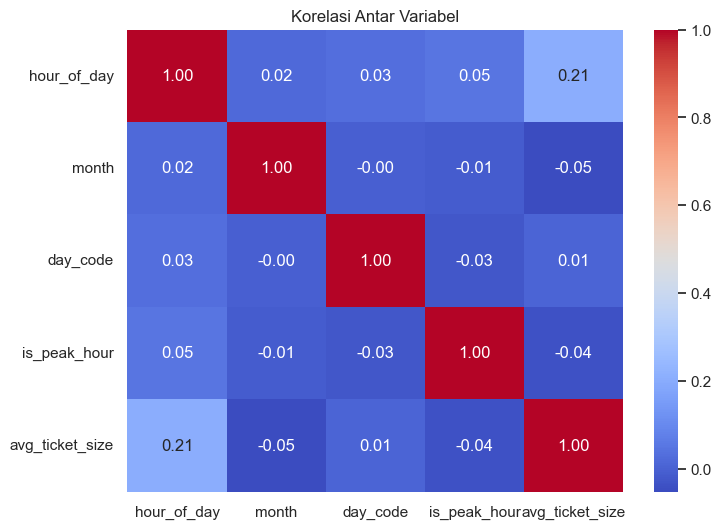

In [16]:
# 1. LOAD DATA
print("\n--- [STEP 1] LOAD & CLEAN DATA ---")
df = pd.read_csv('Coffe_sales.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

print("Info Data:")
df.info()

# 2. EDA (EXPLORATORY DATA ANALYSIS)
print("\n--- [STEP 2] EDA ---")

# (A) Distribusi Transaksi per Jam
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='hour_of_day', bins=16, kde=True, color='skyblue')
plt.title('Distribusi Jumlah Transaksi Berdasarkan Jam Operasional')
plt.xlabel('Jam Transaksi')
plt.ylabel('Jumlah Transaksi')
plt.show()

# (B) Top 10 Produk
plt.figure(figsize=(10, 6))
top_products = df['coffee_name'].value_counts().head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Jenis Kopi dengan Transaksi Terbanyak')
plt.xlabel('Jumlah Transaksi')
plt.show()

# (C) Transaksi per Hari
df['Weekday'] = df['Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Weekday', order=day_order, palette='viridis')
plt.title('Jumlah Transaksi Berdasarkan Hari')
plt.xticks(rotation=45)
plt.show()

# (D) Heatmap Hari vs Jam
df_heatmap = df.groupby(['Weekday', 'hour_of_day']).size().unstack(fill_value=0)
df_heatmap = df_heatmap.reindex(day_order) # Urutkan hari
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap Kepadatan Transaksi (Hari vs Jam)')
plt.show()


# 3. DATA PREPARATION (TRANSFORMASI)
print("\n--- [STEP 3] DATA PREPARATION (AGREGASI & FEATURE ENGINEERING) ---")
df_agg = df.groupby(['Date', 'hour_of_day']).agg({
    'coffee_name': 'count',
    'money': 'mean'
}).reset_index()

df_agg.rename(columns={'coffee_name': 'order_count', 'money': 'avg_ticket_size'}, inplace=True)

# Tambah Fitur Waktu
df_agg['day_name'] = df_agg['Date'].dt.day_name()
df_agg['month'] = df_agg['Date'].dt.month

# Labeling Target: Peak Hour (1) jika order > Threshold
threshold = df_agg['order_count'].quantile(0.75)
df_agg['is_peak_hour'] = (df_agg['order_count'] > threshold).astype(int)

# Encoding Hari (Categorical -> Numeric)
le = LabelEncoder()
df_agg['day_code'] = le.fit_transform(df_agg['day_name'])

print(f"Threshold Peak Hour: > {threshold} order/jam")
print("Data Siap Modeling:")
display(df_agg.head())

# Korelasi Fitur
plt.figure(figsize=(8, 6))
sns.heatmap(df_agg[['hour_of_day', 'month', 'day_code', 'is_peak_hour', 'avg_ticket_size']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Variabel')
plt.show()

### BAGIAN 2: VIDEO 1 - BASELINE MODEL & SVM
### Membandingkan Naive Bayes, Random Forest (Awal), dan SVM

In [17]:
print("\n" + "="*50)
print("  VIDEO 1: PEMODELAN AWAL (NB, RF) & EKSPERIMEN SVM")
print("="*50)

# 1. Split Data
X = df_agg[['hour_of_day', 'day_code', 'month']]
y = df_agg['is_peak_hour']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Scaling (Penting buat SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Komparasi Model
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest (Base)": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (Eksperimen Baru)": SVC(kernel='rbf', random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n--- {name} ---")
    print(f"Akurasi: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))


  VIDEO 1: PEMODELAN AWAL (NB, RF) & EKSPERIMEN SVM

--- Naive Bayes ---
Akurasi: 0.83
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       336
           1       0.00      0.00      0.00        71

    accuracy                           0.83       407
   macro avg       0.41      0.50      0.45       407
weighted avg       0.68      0.83      0.75       407



C:\Users\DANANG ADIWIBOWO\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DANANG ADIWIBOWO\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DANANG ADIWIBOWO\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


--- Random Forest (Base) ---
Akurasi: 0.77
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       336
           1       0.23      0.13      0.16        71

    accuracy                           0.77       407
   macro avg       0.53      0.52      0.51       407
weighted avg       0.73      0.77      0.74       407


--- SVM (Eksperimen Baru) ---
Akurasi: 0.83
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       336
           1       0.00      0.00      0.00        71

    accuracy                           0.83       407
   macro avg       0.41      0.50      0.45       407
weighted avg       0.68      0.83      0.75       407



C:\Users\DANANG ADIWIBOWO\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DANANG ADIWIBOWO\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DANANG ADIWIBOWO\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### BAGIAN 3: VIDEO 2 - HANDLING IMBALANCED DATA
### Menggunakan augmentasi untuk mengatasi data yang tidak seimbang



  VIDEO 2: SOLUSI DATA BIAS (AUGMENTASI SMOTE)
Jumlah Data Train Sebelum SMOTE: Counter({0: 1341, 1: 284})
Jumlah Data Train Setelah SMOTE: Counter({1: 1341, 0: 1341})

--- HASIL RANDOM FOREST + SMOTE ---
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       336
           1       0.26      0.21      0.23        71

    accuracy                           0.76       407
   macro avg       0.55      0.54      0.55       407
weighted avg       0.74      0.76      0.75       407



C:\Users\DANANG ADIWIBOWO\AppData\Local\Temp\ipykernel_28400\647457553.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


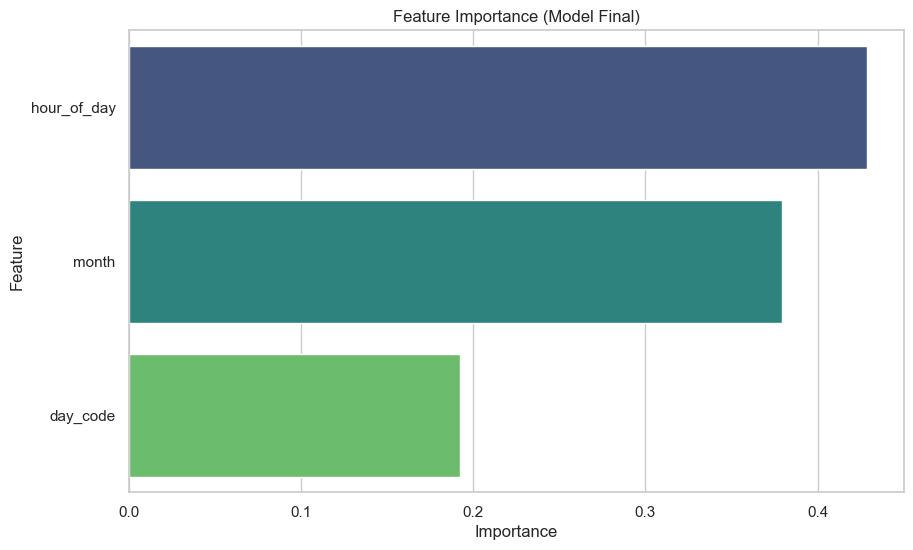

In [ ]:
print("\n\n" + "="*50)
print("  VIDEO 2: SOLUSI DATA BIAS (AUGMENTASI SMOTE)")
print("="*50)

# 1. Cek Distribusi Sebelum
print(f"Jumlah Data Train Sebelum SMOTE: {Counter(y_train)}")

# 2. Penerapan SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"Jumlah Data Train Setelah SMOTE: {Counter(y_train_smote)}")

# 3. Retrain Random Forest dengan Data Baru
rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(X_train_smote, y_train_smote)
y_pred_final = rf_final.predict(X_test_scaled)

# 4. Evaluasi
print("\n--- HASIL RANDOM FOREST + SMOTE ---")
print(classification_report(y_test, y_pred_final))

# Feature Importance (Sesuai notebook asli)
importances = rf_final.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title('Feature Importance (Model Final)')
plt.show()

### BAGIAN 4: VIDEO 3 - REGRESSION MODELS (LINEAR & LOGISTIC)
### Prediksi Nominal Transaksi & Alternatif Klasifikasi



  VIDEO 3: LINEAR MODELS (REGRESSION & CLASSIFICATION)
Akurasi Logistic Regression: 0.5331695331695332

--- Linear Regression (Jam vs Jumlah Order) ---


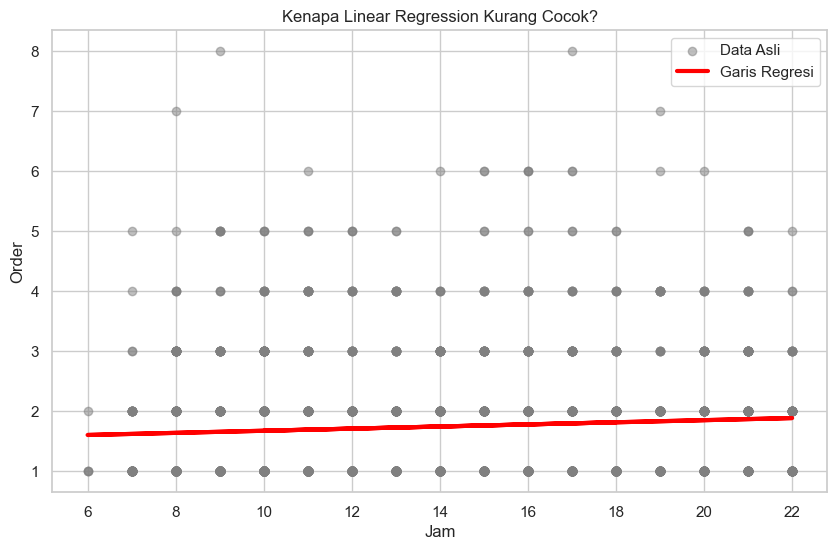

Insight: Garis merah gagal menangkap pola naik-turun jam sibuk.


In [ ]:
print("\n\n" + "="*50)
print("  VIDEO 3: LINEAR MODELS (REGRESSION & CLASSIFICATION)")
print("="*50)

# A. Logistic Regression (Klasifikasi)
log_model = LogisticRegression()
log_model.fit(X_train_smote, y_train_smote)
y_pred_log = log_model.predict(X_test_scaled)
print("Akurasi Logistic Regression:", accuracy_score(y_test, y_pred_log))

# B. Linear Regression (Prediksi Jumlah Order)
print("\n--- Linear Regression (Jam vs Jumlah Order) ---")
X_reg = df_agg[['hour_of_day']]
y_reg = df_agg['order_count']

lin_reg = LinearRegression()
lin_reg.fit(X_reg, y_reg)
y_reg_pred = lin_reg.predict(X_reg)

# Visualisasi
plt.figure(figsize=(10, 6))
plt.scatter(X_reg, y_reg, color='gray', alpha=0.5, label='Data Asli')
plt.plot(X_reg, y_reg_pred, color='red', linewidth=3, label='Garis Regresi')
plt.title('Kenapa Linear Regression Kurang Cocok?')
plt.xlabel('Jam')
plt.ylabel('Order')
plt.legend()
plt.show()
print("Insight: Garis merah gagal menangkap pola naik-turun jam sibuk.")

### BAGIAN 5: VIDEO 4 - TIME SERIES ANALYSIS
### Menganalisis Tren & Pola Musiman Data Penjualan



  VIDEO 4: TIME SERIES ANALYSIS


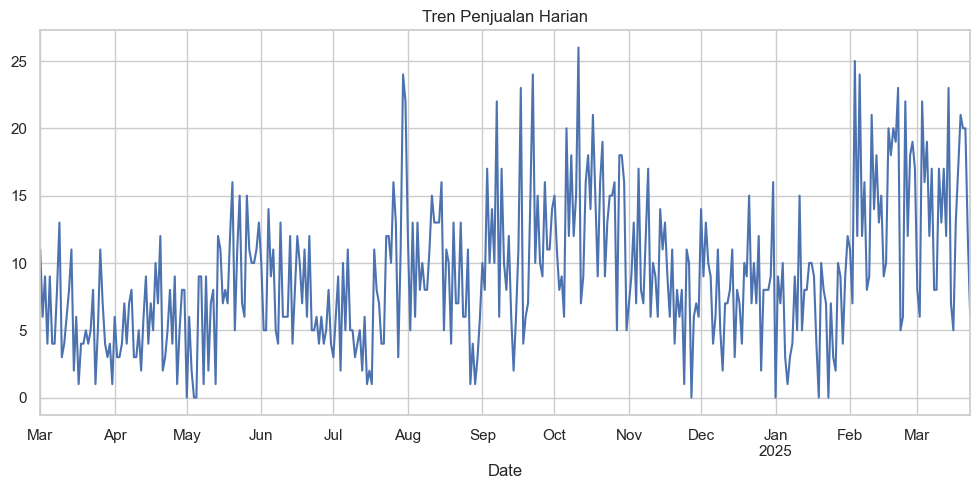

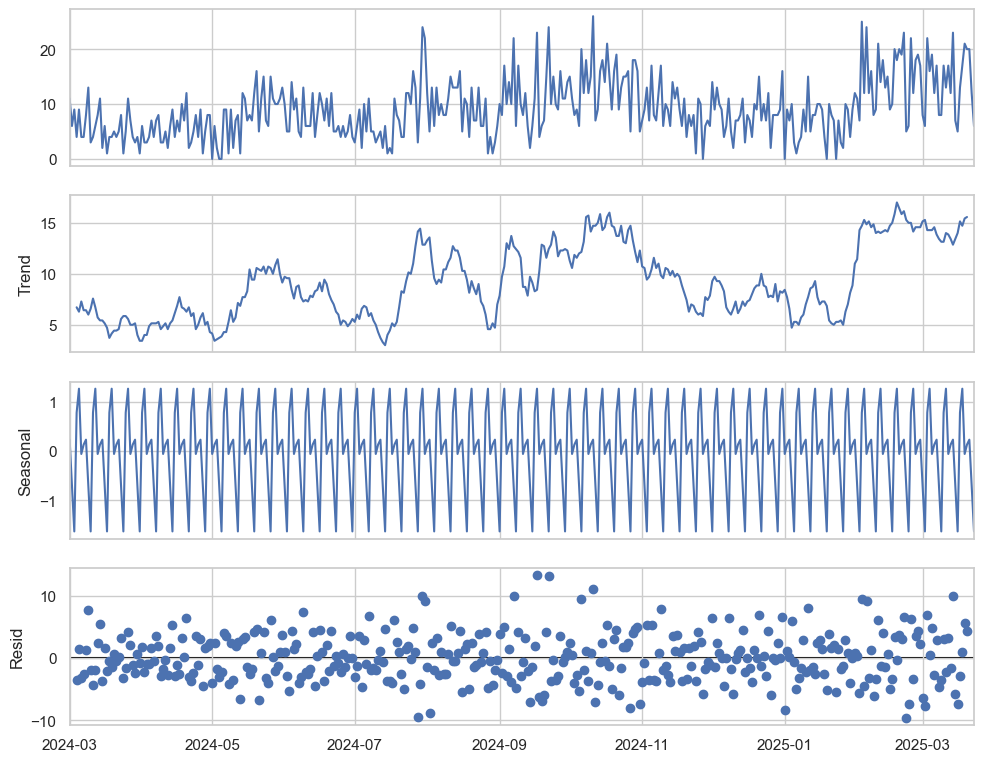

Insight: Pola mingguan (Seasonal) terlihat jelas.


In [ ]:
print("\n\n" + "="*50)
print("  VIDEO 4: TIME SERIES ANALYSIS")
print("="*50)

# Resampling ke Harian
df_ts = df.set_index('Date').resample('D').size()

plt.figure(figsize=(12, 5))
df_ts.plot(title='Tren Penjualan Harian')
plt.show()

# Dekomposisi Musiman (Mingguan)
if len(df_ts) > 14:
    decomposition = seasonal_decompose(df_ts, model='additive', period=7)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.show()
    print("Insight: Pola mingguan (Seasonal) terlihat jelas.")


### Save Model

In [21]:
import joblib
from sklearn.ensemble import RandomForestClassifier

# 1. Definisi & Latih Model (Wajib biar variable rf_smote ada isinya)
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# 2. Simpan file ke folder komputer (Local)
joblib.dump(rf_smote, 'model_final.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'le_day.pkl')
df_agg.to_csv('clean_data_agg.csv', index=False)

print("Selesai. File sudah muncul di folder ini.")

Selesai. File sudah muncul di folder ini.
